In [1]:
## Lidar autocovariance function

In [1]:
import xarray as xr
import numpy as np
from scipy.signal import periodogram, welch
from scipy.integrate import trapz
from scipy.interpolate import interp1d
from scipy.ndimage import convolve1d, maximum_filter
from scipy.signal import argrelextrema, hann
import pyart
from scipy.signal import find_peaks
%pylab inline
import cupy as cp

ModuleNotFoundError: No module named 'pyart'

In [2]:
acf_ds = xr.open_dataset('/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170801.130112.nc.v0')

In [363]:
acf_ds

<xarray.Dataset>
Dimensions:      (complex: 2, nlags: 20, nsamples: 4000, time: 2184)
Coordinates:
  * time         (time) datetime64[ns] 2017-08-01T13:01:12.830000 ... 2017-08-01T13:59:59.940000
  * complex      (complex) int16 1 2
  * nlags        (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: nsamples
Data variables:
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    azimuth      (time) float32 ...
    elevation    (time) float32 ...
    acf_bkg      (nsamples, nlags, complex) float32 ...
    acf          (time, nsamples, nlags, complex) float32 ...
    lat          float32 ...
    lon          float32 ...
    alt          float32 ...
Attributes:
    command_line:          dlacf_ingest -s sgp -f C1 -D
    Conventions:           ARM-1.2
    process_version:       ingest-dlacf-1.0-0.el6
    dod_version:           dlacf-a1-1.0
    input_source:          /data/collection/sgp/sgpdlacfC1.00/aet_Stare_107_2...

In [298]:
acf_ds['time']

<xarray.DataArray 'time' (time: 2181)>
array(['2017-08-01T08:01:13.129999000', '2017-08-01T08:01:14.680000000',
       '2017-08-01T08:01:16.220000000', ..., '2017-08-01T08:59:56.840000000',
       '2017-08-01T08:59:58.380000000', '2017-08-01T08:59:59.930000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-08-01T08:01:13.129999 ... 2017-08-01T08:59:59.930000
Attributes:
    long_name:      Time offset from midnight
    standard_name:  time

In [162]:
g = 3*np.ones(4)
g = g[:, np.newaxis, np.newaxis]
g

array([[[3.]],

       [[3.]],

       [[3.]],

       [[3.]]])

In [ ]:
my_spectra['acf_bkg']

In [4]:
cuda.select_device(0)

<weakproxy at 0x7f5b0c5026d8 to Device at 0x7f5b0c52b588>

In [3]:
# Welch's method with Hann window function, returns power spectrum, written for the GPU
def welchs_method(complex_coeff, fs=50e6, nfft=32, window_skip=16, num_per_block=200):
    # Can't send whole array to GPU, just pieces
    times = complex_coeff.shape[0]
    num_blocks = times
    num_points = complex_coeff.shape[-1]
    window = hann(nfft)
    if len(complex_coeff.shape) == 3:
        my_fft = np.zeros((complex_coeff.shape[0], complex_coeff.shape[1], nfft))
        for k in range(0, times, num_per_block):
            j = 0
            the_max = min([k+num_per_block, times])
            gpu_complex = cp.array(complex_coeff[k:the_max, :, :])
            windowt = cp.tile(window, ((gpu_complex.shape[0], gpu_complex.shape[1],1)))
            temp_fft = cp.zeros((gpu_complex.shape[0], gpu_complex.shape[1], nfft))
            for i in range(0, num_points, window_skip):
                if i + nfft > num_points:
                    start = num_points - nfft
                    temp_fft += cp.square(cp.abs(cp.fft.fft(gpu_complex[:,:,start:]*windowt, axis=-1)))
                else:
                    temp_fft += cp.square(cp.abs(cp.fft.fft(gpu_complex[:,:,i:i+nfft]*windowt, axis=-1)))
                j += 1
            temp_fft = temp_fft / j
            my_fft[k:the_max] = temp_fft.get()
    elif len(complex_coeff.shape) == 2:
        my_fft = np.zeros((complex_coeff.shape[0], nfft))
        j = 0
        gpu_complex = cp.array(complex_coeff)
        windowt = cp.tile(window, ((gpu_complex.shape[0],1)))
        temp_fft = cp.zeros((gpu_complex.shape[0], nfft))
        for i in range(0, num_points, window_skip):
            if i + nfft > num_points:
                start = num_points - nfft
                temp_fft += cp.square(cp.abs(cp.fft.fft(gpu_complex[:,start:]*windowt, axis=-1)))
            else:
                temp_fft += cp.square(cp.abs(cp.fft.fft(gpu_complex[:,i:i+nfft]*windowt, axis=-1)))
            j += 1
        temp_fft = temp_fft / j
        my_fft = temp_fft.get()
    power = my_fft
    freq = np.fft.fftfreq(nfft)*fs
    
    return freq, np.array(power)

def fast_expand(complex_array, factor, num_per_block=200):
    shp = complex_array.shape
    times = shp[0]
    expanded_array = np.zeros((shp[0], shp[1], shp[2]*factor))
    for k in range(0, times, num_per_block):
        the_max = min([k+num_per_block, times])
        weights = cp.tile(np.arange(0, factor)/factor, (the_max-k, shp[1], 1))
        for l in range(shp[2]):
            gpu_array = cp.array(complex_array[k:the_max, :, l])
            if l < shp[2]-1:
                gpu_array2 = cp.array(complex_array[k:the_max, :, l+1])
                diff_array = gpu_array2 - gpu_array
            else:
                diff_array = cp.zeros((the_max - k , shp[1]))
                
            rep_array = cp.transpose(
                cp.tile(gpu_array, (factor, 1, 1)), [1, 2, 0])
            diff_array = cp.transpose(
                cp.tile(diff_array, (factor, 1, 1)), [1, 2, 0])
            temp_array = diff_array*weights + rep_array
            expanded_array[k:the_max, :, factor*l:factor*(l+1)] = temp_array.get()
    return expanded_array

def gpu_moving_average(arr, num_per_block=200, window=8):
    shp = arr.shape
    times = shp[0]
    for k in range(0, times, num_per_block):
        the_max = min([k+num_per_block, times])
        gpu_arr = cp.array(arr[k:the_max, :, :])
        gpu_arr2 = cp.zeros_like(gpu_arr)
        for i in range(shp[2]):
            the_max2 = min([i+window, shp[2]])
            gpu_arr2[:, :, i] = cp.mean(gpu_arr[:, :, i:the_max2], axis=2)
        arr[k:the_max, : :] = gpu_arr2.get()
        del gpu_arr, gpu_arr2
    return arr

def get_psd(spectra, gate_resolution=30):
    wavelength = 1.548e-6
    num_gates = int(gate_resolution/3)
    complex_coeff = spectra['acf'].sel(complex=1).values + spectra['acf'].sel(complex=2).values * 1j
    complex_coeff = np.reshape(complex_coeff, 
                               (complex_coeff.shape[0], 
                                int(complex_coeff.shape[1]/num_gates), 
                                int(complex_coeff.shape[2]*num_gates)))
    num_time_bins = complex_coeff.shape[0]
    num_freq_bins = complex_coeff.shape[2]*num_gates
    freq, power = welchs_method(complex_coeff, fs=50e6, nfft=32)
    spectra['range'] = xr.DataArray(gate_resolution*np.arange(int(complex_coeff.shape[1])),
                                    dims=('range'))
    spectra.attrs['nyquist_velocity'] = 1548e-9/(4*1/50e6)
    spectra['freq_bins'] = xr.DataArray(freq, dims=['freq'])
    vel_bins = spectra['freq_bins']*(wavelength/2)
    inds_sorted = np.argsort(vel_bins.values)
    vel_bins = vel_bins[inds_sorted]
    spectra['vel_bins'] = xr.DataArray(vel_bins, dims=('vel_bins'))
    spectra['freq_bins'] = spectra['freq_bins'][inds_sorted]
    spectra['power'] = xr.DataArray(power[:, :, inds_sorted], dims=(('time', 'range', 'vel_bins')),) 
 
    complex_coeff = spectra['acf_bkg'].sel(complex=1).values + spectra['acf_bkg'].sel(complex=2).values * 1j
    complex_coeff = np.reshape(complex_coeff,
                               (int(complex_coeff.shape[0]/num_gates), int(complex_coeff.shape[1]*num_gates)))
    freq, power = welchs_method(complex_coeff, fs=50e6, nfft=32)
    spectra['power_bkg'] = xr.DataArray(power[:, inds_sorted], dims=(('range', 'vel_bins')))
    
    # Subtract background noise
    #power_bkg_tiled = np.tile(power[:, inds_sorted], (num_time_bins, 1, 1))
    spectra['power_spectral_density'] = spectra['power'] - spectra['power_bkg']
    spectra['power_spectral_density'] = spectra['power_spectral_density'].where(
        spectra['power_spectral_density'] > 0, 0)
    tot_power = np.sum(spectra['power_spectral_density'].values, axis=2)
    dV = np.diff(spectra['vel_bins'])
    power_tiled = np.stack([tot_power for x in range(spectra['power'].values.shape[2])], axis=2)
    spectra['power_spectra_normed'] = spectra['power_spectral_density'] / power_tiled / dV[1] * 100
    spectra['power_spectral_density'] = 10*np.log10(spectra['power_spectral_density'])/dV[1]
    spectra['power_spectral_density'].attrs["units"] = 's dB-1 m-1 '
    
    
    # Smooth out power spectra
    num_points = 8
    interpolated_bins = np.linspace(spectra['vel_bins'].values[0], spectra['vel_bins'].values[-1], 256)
    spectra['vel_bin_interp'] = xr.DataArray(interpolated_bins, dims=('vel_bin_interp'))
    my_array = gpu_moving_average(
        fast_expand(spectra['power_spectral_density'].values, 8))
    spectra['power_spectral_density_interp'] = xr.DataArray(my_array,
                                                            dims=('time', 'range', 'vel_bin_interp'),
                                                            )
    my_array = gpu_moving_average(
        fast_expand(spectra['power_spectra_normed'].values, 8))
    spectra['power_spectra_normed_interp'] = xr.DataArray(my_array,
                                                          dims=('time', 'range', 'vel_bin_interp'),
                                                          )
    return spectra

In [364]:
%time my_spectra = get_psd(ds)

NameError: name 'ds' is not defined

In [144]:
new_bins = np.append(acf_ds['vel_bins'].values, 19.35)
print((new_bins[1:]+new_bins[:-1])/2.0)

[-18.7453125 -17.5359375 -16.3265625 -15.1171875 -13.9078125 -12.6984375
 -11.4890625 -10.2796875  -9.0703125  -7.8609375  -6.6515625  -5.4421875
  -4.2328125  -3.0234375  -1.8140625  -0.6046875   0.6046875   1.8140625
   3.0234375   4.2328125   5.4421875   6.6515625   7.8609375   9.0703125
  10.2796875  11.4890625  12.6984375  13.9078125  15.1171875  16.3265625
  17.5359375  18.7453125]


In [145]:
acf_ds['vel_bins']

<xarray.DataArray 'vel_bins' (vel_bins: 32)>
array([-19.35    , -18.140625, -16.93125 , -15.721875, -14.5125  , -13.303125,
       -12.09375 , -10.884375,  -9.675   ,  -8.465625,  -7.25625 ,  -6.046875,
        -4.8375  ,  -3.628125,  -2.41875 ,  -1.209375,   0.      ,   1.209375,
         2.41875 ,   3.628125,   4.8375  ,   6.046875,   7.25625 ,   8.465625,
         9.675   ,  10.884375,  12.09375 ,  13.303125,  14.5125  ,  15.721875,
        16.93125 ,  18.140625])
Coordinates:
  * vel_bins  (vel_bins) float64 -19.35 -18.14 -16.93 ... 15.72 16.93 18.14

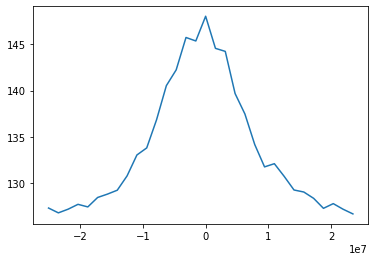

In [99]:
plt.plot(acf_ds['freq_bins'], 10*np.log10(acf_ds['power_bkg'][1]))

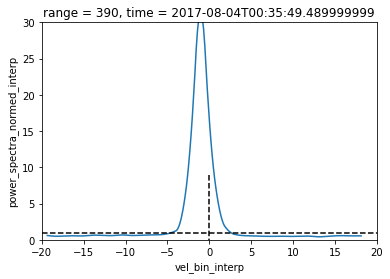

In [17]:
acf_ds.sel(time=datetime.datetime(2017, 8, 4, 0, 35, 50), range=400., method='nearest')['power_spectra_normed_interp'].plot()
plt.ylim([0, 30])
plt.xlim([-20, 20])
plt.plot([-20, 20], [1, 1], color='k', linestyle='--')
plt.plot([0, 0], [9, 0], color='k', linestyle='--')

In [29]:
cp.max?

In [4]:
# Peak detection on the GPU
def gpu_moving_std(arr, num_per_block=200, window=8):
    shp = arr.shape
    times = shp[0]
    for k in range(0, times, num_per_block):
        the_max = min([k+num_per_block, times])
        gpu_arr = cp.array(arr[k:the_max, :, :])
        gpu_arr2 = cp.zeros_like(gpu_arr)
        for i in range(shp[2]):
            the_max2 = min([i+window, shp[2]])
            gpu_arr2[:, :, i] = cp.std(gpu_arr[:, :, i:the_max2], axis=2)
        gpu_arr2 = cp.where(gpu_arr2 > 0, gpu_arr2, 1)
        arr[k:the_max, : :] = gpu_arr2.get()
        del gpu_arr, gpu_arr2
    return arr

def gpu_median(arr, num_per_block=200):
    shp = arr.shape
    times = shp[0]
    arr_new = np.zeros(shp[0], shp[1])
    for k in range(0, times, num_per_block):
        the_max = min([k+num_per_block, times])
        gpu_arr = cp.array(arr[k:the_max, :, :])
        gpu_arr = cp.percentile(gpu_arr, 50, axis=2)
        arr_new[k:the_max, :] = gpu_arr.get()
        del gpu_arr
    return arr_new    

# Since we have constant dx, we can just assume dx = 1 and use diff
def gpu_gradient(arr, num_per_block=200, order=1):
    if order < 1 or not isinstance(order, int):
        raise ValueError("Derivative order must be a positive integer!")
        
    if order == 1:
        shp = arr.shape
        times = shp[0]
        arr_new = np.zeros_like(arr)
        for k in range(0, times, num_per_block):
            the_max = min([k+num_per_block, times])
            gpu_arr = cp.array(arr[k:the_max, :, :])
            diff_arr = cp.zeros_like(gpu_arr)
            diff_arr[:, :, 0] = gpu_arr[:, :, 1] - gpu_arr[:, :, 0]
            diff_arr[:, :, 1:-1] = (gpu_arr[:, :, 2:] - gpu_arr[:, :, :-2])/2.
            diff_arr[:, :, -1] = gpu_arr[:, :, -1] - gpu_arr[:, :, -2]
            arr_new[k:the_max, :, :] = diff_arr.get()
        del gpu_arr
        return arr_new
    else:
        return gpu_gradient(gpu_gradient(arr, num_per_block, order=order-1)
                            , num_per_block=num_per_block, order=1)

In [333]:
from scipy.signal import find_peaks

def calc_num_peaks(spectra):
    my_array = spectra.fillna(0).values
    shp = my_array.shape
    num_peaks = np.zeros((shp[0], shp[1]))
    for i in range(shp[0]):
        for j in range(shp[1]):
            num_peaks[i,j] = len(find_peaks(my_array[i,j], height=3, width=8)[0])
    return num_peaks

In [334]:
%time my_spectra['npeaks'] = xr.DataArray(calc_num_peaks(acf_ds['power_spectra_normed_interp']), dims=('time','range'))

/home/rjackson/.conda/envs/cuda_radar_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: PeakPropertyWarning: some peaks have a width of 0
  if __name__ == '__main__':


CPU times: user 49.8 s, sys: 1.2 s, total: 51 s
Wall time: 51.4 s


Text(0.5, 1.0, 'Aug 04 2017, SNR > 0 dB')

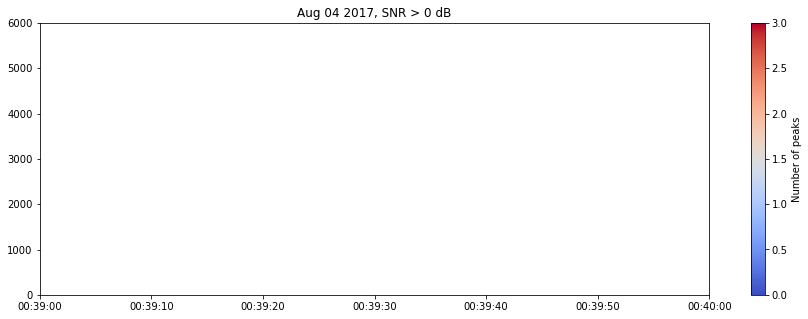

In [207]:
plt.figure(figsize=(15,5))
npeaks = my_spectra['npeaks']
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
plt.pcolormesh(x, y, npeaks.values.T, vmin=0, vmax=3, cmap='coolwarm')
plt.colorbar(label='Number of peaks')
plt.ylim([0, 6000])
plt.xlim([datetime.datetime(2017,8,4,00,39, 00), datetime.datetime(2017,8,4,00,40,00)])
plt.title('Aug 04 2017, SNR > 0 dB')

<>:5: DeprecationWarning: invalid escape sequence \ 
<>:5: DeprecationWarning: invalid escape sequence \ 
<>:5: DeprecationWarning: invalid escape sequence \ 
<ipython-input-149-07a54001e894>:5: DeprecationWarning: invalid escape sequence \ 
  plt.ylabel('Power Spectral Density $dB\ s\ m^{-1}$')


(array([125]), {'peak_heights': array([27.7245108]), 'prominences': array([27.15429995]), 'left_bases': array([51]), 'right_bases': array([197]), 'widths': array([15.07693024]), 'width_heights': array([14.14736083]), 'left_ips': array([117.38912672]), 'right_ips': array([132.46605696])})


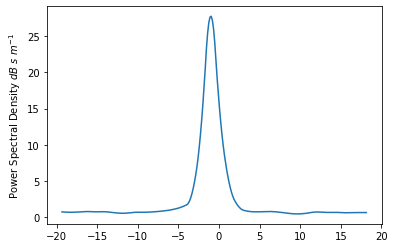

In [149]:
psd = my_spectra['power_spectra_normed_interp']
plt.plot(my_spectra['vel_bin_interp'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 39, 20), range=200., method='nearest')
         )
plt.ylabel('Power Spectral Density $dB\ s\ m^{-1}$')
print(find_peaks(psd.sel(time=datetime.datetime(2017, 8, 4, 0, 39, 20), range=200., method='nearest').values, 
                 width=7, height=3))

<>:4: DeprecationWarning: invalid escape sequence \ 
<>:4: DeprecationWarning: invalid escape sequence \ 
<>:4: DeprecationWarning: invalid escape sequence \ 
<ipython-input-31-df83b5c31c79>:4: DeprecationWarning: invalid escape sequence \ 
  plt.colorbar(label='$dB\ s\ m^{-1}$')


(0, 2000)

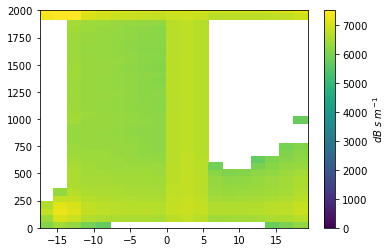

In [31]:
x, y = np.meshgrid(my_spectra['vel_bins'], my_spectra['range'])
plt.pcolormesh(x, y, psd.sel(time=datetime.datetime(2017, 8, 4, 0, 35, 00), method='nearest')*100,
               vmin=0, vmax=7500)
plt.colorbar(label='$dB\ s\ m^{-1}$')
plt.ylim([0, 2000])

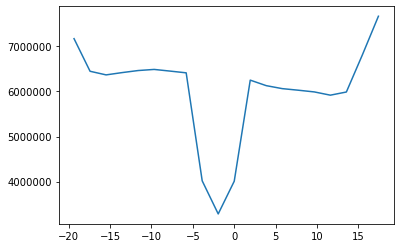

In [12]:
plt.plot(-my_spectra['vel_bins'], 
         my_spectra['power_bkg'].sel(range=300., method='nearest')/50e6*19)

In [5]:
def gpu_calc_power(psd, dV, block_size=200, normed=True):
    shp = psd.shape
    times = shp[0]
    power = np.zeros((shp[0], shp[1]))
    if len(shp) == 3:
        for k in range(0, times, block_size):
            the_max = min([k+block_size, times])
            gpu_array = cp.array(psd[k:the_max, :, :])
            if normed:
                gpu_array = 10**(gpu_array/10.*dV)
            gpu_array = cp.sum(gpu_array, axis=2)
            power[k:the_max] = gpu_array.get()
    else:
        gpu_array = cp.array(psd)
        if normed:
            gpu_array = 10**(gpu_array/10.*dV)
        gpu_array = cp.sum(gpu_array, axis=1)
        power = gpu_array.get()
    
    return power

def gpu_calc_velocity(psd, power, vel_bins, dV, block_size=100):
    shp = psd.shape
    times = shp[0]
    velocity = np.zeros((shp[0], shp[1]))
    for k in range(0, times, block_size):
        the_max = min([k+block_size, times])
        gpu_array = cp.array(psd[k:the_max, :, :], dtype=float64)
        power_array = cp.array(power[k:the_max, :], dtype=float64)
        vel_bins_tiled = cp.tile(vel_bins, (the_max-k, shp[1], 1))
        gpu_array = 10**(gpu_array/10.*dV)
        gpu_array = 1/power_array*cp.sum(gpu_array*vel_bins_tiled, axis=2)
        velocity[k:the_max, :] = gpu_array.get()
    return velocity

def gpu_calc_velocity_dumb(psd, vel_bins, block_size=300):
    shp = psd.shape
    times = shp[0]
    velocity = np.zeros((shp[0], shp[1]))
    # Get dV and vel_min
    dV = np.diff(vel_bins)[0]
    vel_min = vel_bins.min()
    for k in range(0, times, block_size):
        the_max = min([k+block_size, times])
        gpu_array = cp.array(psd[k:the_max, :, :])
        gpu_array = cp.argmax(gpu_array, axis=2)
        gpu_array = vel_min + gpu_array*dV
        velocity[k:the_max, :] = gpu_array.get()
    return velocity

def gpu_calc_spectral_width(psd, power, vel_bins, velocity, dV, block_size=100):
    shp = psd.shape
    times = shp[0]
    specwidth = np.zeros((shp[0], shp[1]))
    for k in range(0, times, block_size):
        the_max = min([k+block_size, times])
        gpu_array = cp.array(psd[k:the_max, :, :], dtype=float64)
        power_array = cp.array(power[k:the_max, :], dtype=float64)
        velocity_array = cp.array(velocity[k:the_max, :])
        velocity_array = cp.transpose(cp.tile(velocity_array, (shp[2], 1, 1)), [1, 2, 0])
        vel_bins_tiled = cp.tile(vel_bins, (the_max-k, shp[1], 1))
        gpu_array = 10**(gpu_array/10.*dV)
        gpu_array = cp.sqrt(1/power_array*cp.sum((vel_bins_tiled - velocity_array)**2 * gpu_array, axis=2))
        specwidth[k:the_max, :] = gpu_array.get()
    return specwidth

def gpu_calc_skewness(psd, power, vel_bins, velocity, spec_width, dV, block_size=100):
    shp = psd.shape
    times = shp[0]
    skewness = np.zeros((shp[0], shp[1]))
    for k in range(0, times, block_size):
        the_max = min([k+block_size, times])
        gpu_array = cp.array(psd[k:the_max, :, :], dtype=float64)
        power_array = cp.array(power[k:the_max, :], dtype=float64)
        spec_width_array = cp.array(spec_width[k:the_max, :], dtype=float64)
        power_array *= spec_width_array**3
        velocity_array = cp.array(velocity[k:the_max, :])
        velocity_array = cp.transpose(cp.tile(velocity_array, (shp[2], 1, 1)), [1, 2, 0])
        vel_bins_tiled = cp.tile(vel_bins, (the_max-k, shp[1], 1))
        gpu_array = 10**(gpu_array/10.*dV)
        gpu_array = 1/power_array*cp.sum((vel_bins_tiled - velocity_array)**3 * gpu_array, axis=2)
        skewness[k:the_max, :] = gpu_array.get()
    return skewness

def gpu_snr(power, noise, block_size=500):
    shp = power.shape
    times = shp[0]
    snr = np.zeros_like(power)
    #or k in range(0, times, block_size):
    #   the_max = min([k+block_size, times])
    gpu_power = cp.array(power)
    gpu_noise = cp.tile(cp.array(noise), (times, 1))
    gpu_power = 10*cp.log10(gpu_power/gpu_noise)
    snr = gpu_power.get()
    return snr
        
def get_power_and_velocity(my_spectra, wavelength=1.548e-6, snr_thresh=0):
    dV = np.diff(my_spectra['vel_bins'])[0]
    linear_psd = my_spectra['power_spectral_density_interp']
    power = gpu_calc_power(linear_psd.fillna(0), dV)
    shp = linear_psd.shape
    # Proper velocity thru integration
    #velocity = 1 / power * trapz(vel_bins_tiled*linear_psd,
    #                             x=spectra['vel_bin_interp'].values, axis=2)
    
    velocity = gpu_calc_velocity(linear_psd.fillna(0), power, my_spectra['vel_bin_interp'].values, dV)
    # Velocity from highest peak

    velocity_dumb = gpu_calc_velocity_dumb(linear_psd.fillna(0), my_spectra['vel_bin_interp'].values)
    
    my_spectra['noise'] = my_spectra['power_bkg'].sum(axis=1)
    linear_power = xr.DataArray(power, dims=('time', 'range'))
    power_with_noise = gpu_calc_power(my_spectra['power'].values, dV, normed=False)
    power_with_noise = xr.DataArray(power_with_noise, dims=('time', 'range'))
    my_spectra['attenuated_backscatter'] = xr.DataArray(10*np.log10(power), dims=('time', 'range'))
    my_spectra['attenuated_backscatter'].attrs['long_name'] = "Attenuated backscatter"
    my_spectra['attenuated_backscatter'].attrs['units'] = "dB"
    
    my_spectra['snr'] = xr.DataArray(gpu_snr(power_with_noise, my_spectra['noise'].values), dims=('time', 'range'))
    my_spectra['snr'].attrs['long_name'] = "Signal to Noise Ratio"
    my_spectra['snr'].attrs['units'] = "dB"
    
    my_spectra['velocity_dumb'] = xr.DataArray(velocity_dumb, dims=('time', 'range'))
    my_spectra['mean_velocity'] = xr.DataArray(velocity, dims=('time', 'range'))
    my_spectra['mean_velocity'].attrs['long_name'] = "Doppler velocity"
    my_spectra['mean_velocity'].attrs['units'] = "m s-1"
    my_spectra['mean_velocity'] = my_spectra['mean_velocity'].where(my_spectra.snr > snr_thresh)
    
    # Number of peaks
    spectral_width = gpu_calc_spectral_width(
        linear_psd, power, my_spectra['vel_bin_interp'].values, velocity, dV)
    my_spectra['spectral_width'] = xr.DataArray(spectral_width, dims=('time', 'range'))
    my_spectra['spectral_width'] = my_spectra['spectral_width'].where(my_spectra.snr > snr_thresh)
    spectral_width = gpu_calc_skewness(
        linear_psd, power, my_spectra['vel_bin_interp'].values, velocity, spectral_width, dV)
    my_spectra['skewness'] = xr.DataArray(spectral_width, dims=('time', 'range'))
    my_spectra['skewness'] = my_spectra['skewness'].where(my_spectra.snr > snr_thresh)
    my_spectra['velocity_dumb'] = my_spectra['velocity_dumb'].where(my_spectra.snr > snr_thresh)
    return my_spectra

In [345]:
%time my_spectra = get_power_and_velocity(my_spectra)

<xarray.DataArray 'power_spectral_density_interp' ()>
array(158.75664756)
2.512037111141991e+20
CPU times: user 10.9 s, sys: 4.64 s, total: 15.5 s
Wall time: 18 s


In [281]:
my_spectra['spectral_width']

<xarray.DataArray 'spectral_width' (time: 2184, range: 400)>
array([[       nan,        nan, 4.82528606, ...,        nan,        nan,
               nan],
       [       nan,        nan, 4.53927267, ...,        nan,        nan,
               nan],
       [2.38721482, 3.85725172, 5.06497535, ...,        nan,        nan,
               nan],
       ...,
       [2.60430232, 4.08628958, 6.46518352, ...,        nan,        nan,
               nan],
       [2.61129276, 4.02708668, 6.82841783, ...,        nan,        nan,
               nan],
       [2.4821966 , 3.9675673 , 6.49846587, ...,        nan,        nan,
               nan]])
Coordinates:
  * range    (range) int64 0 30 60 90 120 150 ... 11850 11880 11910 11940 11970
  * time     (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000

In [192]:
plt.figure(figsize=(15,5))
my_spectra['attenuated_backscatter'].T.plot(cmap='pyart_HomeyerRainbow')
plt.ylim([0, 6000])

KeyError: 'attenuated_backscatter'

<Figure size 1080x360 with 0 Axes>

In [334]:
dV = np.diff(my_spectra['vel_bins'])
plt.plot(trapz(10**(my_spectra['power_spectral_density_interp']/10.*dV[1], x=my_spectra['vel_bin_interp'].values, 
               axis=2))[4])

SyntaxError: invalid syntax (<ipython-input-334-1e8bb12bacbe>, line 2)

In [288]:
my_spectra['snr']

<xarray.DataArray 'snr' (time: 2184, range: 400)>
array([[-4.52793839e+00, -5.00435860e+00,  5.17421407e+00, ...,
        -6.68060941e-03,  2.31526776e-02,  1.40282609e-02],
       [-1.31659450e+01, -1.24567534e+01,  4.89511134e+00, ...,
        -3.77114341e-03, -2.63402879e-02, -1.40345644e-02],
       [ 2.59089741e+00,  2.83666144e+00,  4.69871512e+00, ...,
        -2.52691287e-02, -1.71219237e-02, -1.17904360e-02],
       ...,
       [ 2.33909123e+00,  2.73709887e+00,  1.57281721e+00, ...,
         3.43058558e-02,  2.10674893e-03, -8.30736728e-03],
       [ 2.28779813e+00,  2.67880425e+00,  1.53941794e+00, ...,
        -3.97758419e-02,  3.35383659e-03, -1.59281710e-03],
       [ 2.49206595e+00,  2.91337287e+00,  1.54701446e+00, ...,
        -3.01307350e-02,  3.88234540e-04,  1.37498024e-03]])
Coordinates:
  * range    (range) int64 0 30 60 90 120 150 ... 11850 11880 11910 11940 11970
  * time     (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
Attribu

Text(0.5, 1.0, 'Aug 04 2017, SNR > 0 dB')

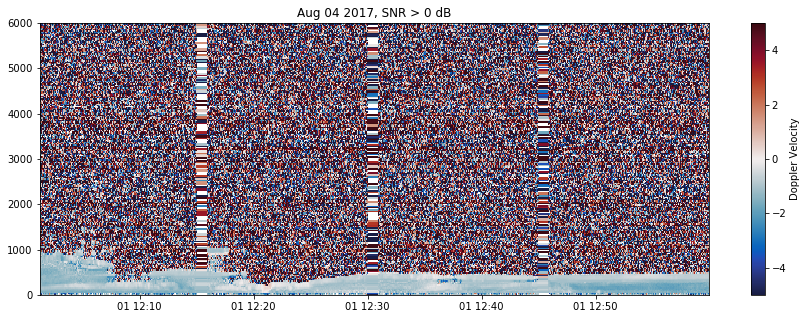

In [346]:
plt.figure(figsize=(15,5))
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
plt.pcolormesh(x, y, my_spectra['mean_velocity'].values.T, vmin=-5, vmax=5, cmap='pyart_balance')
plt.colorbar(label='Doppler Velocity')
plt.ylim([0, 6000])
plt.title('Aug 04 2017, SNR > 0 dB')

In [347]:
plt.figure(figsize=(15,5))
my_spectra['npeaks_masked'] = my_spectra['npeaks'].where(my_spectra.snr >= 0.5)
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
plt.pcolormesh(x, y, my_spectra['npeaks_masked'].values.T, vmin=1, vmax=3, cmap='spring')
plt.colorbar(label='Number of modes', ticks=[1,2,3])
plt.ylim([0, 10000])
plt.title('Aug 04 2017, SNR > -15 dB')

KeyError: 'npeaks'

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, 'Aug 04 2017')

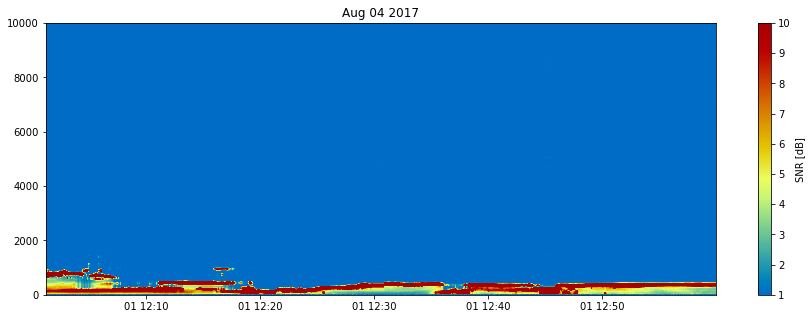

In [348]:
my_spectra['intensity'] = my_spectra['snr']+1
plt.figure(figsize=(15,5))
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
plt.pcolormesh(x, y, my_spectra['intensity'].values.T, vmin=1, vmax=10, cmap='pyart_HomeyerRainbow')
plt.colorbar(label='SNR [dB]')
plt.ylim([0, 10000])
plt.title('Aug 04 2017')

<xarray.DataArray 'time' (time: 2180)>
array(['2017-08-01T12:01:13.680000000', '2017-08-01T12:01:15.230000000',
       '2017-08-01T12:01:16.770000000', ..., '2017-08-01T12:59:55.820000000',
       '2017-08-01T12:59:57.360000000', '2017-08-01T12:59:58.900000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-08-01T12:01:13.680000 ... 2017-08-01T12:59:58.900000


Text(0.5, 1.0, 'Aug 04 2017')

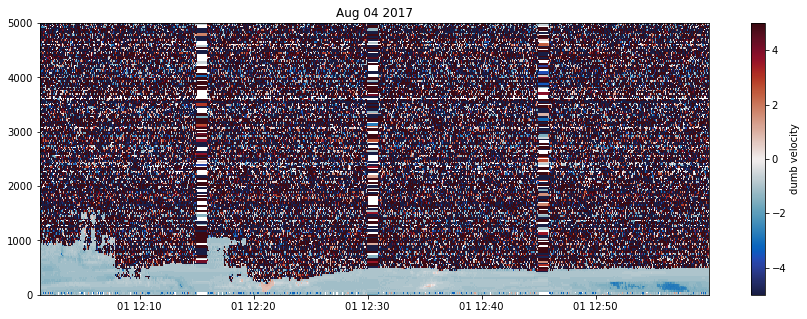

In [349]:
plt.figure(figsize=(15,5))
print(my_spectra['time'])
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
my_spectra['spectral_width_masked'] = my_spectra['spectral_width'].where(my_spectra.snr > 0.5)
plt.pcolormesh(x, y, my_spectra['velocity_dumb'].values.T, vmin=-5, vmax=5, cmap='pyart_balance')
plt.colorbar(label='dumb velocity')
plt.ylim([0, 5000])
plt.title('Aug 04 2017')

<xarray.DataArray 'time' (time: 2181)>
array(['2017-08-01T09:01:13.390000000', '2017-08-01T09:01:14.940000000',
       '2017-08-01T09:01:16.480000000', ..., '2017-08-01T09:59:56.470000000',
       '2017-08-01T09:59:58.010000000', '2017-08-01T09:59:59.550000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-08-01T09:01:13.390000 ... 2017-08-01T09:59:59.550000


Text(0.5, 1.0, 'Aug 04 2017')

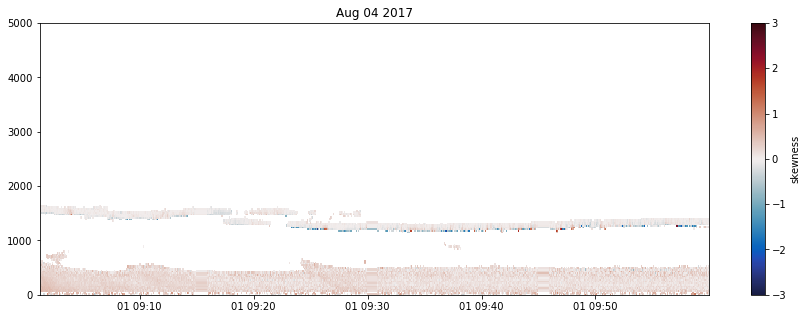

In [317]:
plt.figure(figsize=(15,5))
print(my_spectra['time'])
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
my_spectra['skewness'] = my_spectra['skewness'].where(my_spectra.snr > 0.5)
plt.pcolormesh(x, y, my_spectra['skewness'].values.T, vmin=-3, vmax=3, cmap='pyart_balance')
plt.colorbar(label='skewness')
plt.ylim([0, 5000])
plt.title('Aug 04 2017')

In [82]:
from sklearn.cluster import KMeans
x, y = np.meshgrid(my_spectra['time'].values, my_spectra['range'].values)
kmeans = KMeans(n_clusters=5, random_state=0)
spwidth = my_spectra['skewness'].values.flatten()
velocity = y.flatten()
inds = np.logical_and(np.isfinite(spwidth), np.isfinite(velocity))
X = np.stack([spwidth[inds], velocity[inds]])
print(X.shape)
kmeans.fit(X.T)

(2, 57816)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [83]:
kmeans.cluster_centers_

array([[4.33576524e-02, 5.73523225e+03],
       [9.47737910e-02, 3.46847837e+03],
       [2.99961231e-01, 1.06824487e+04],
       [3.99308165e-01, 8.01256529e+03],
       [6.75151446e-02, 1.13998442e+03]])

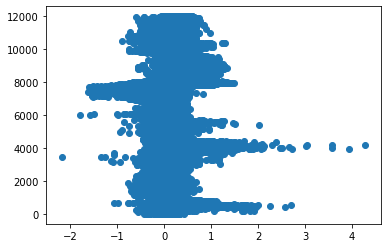

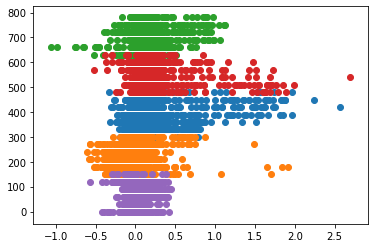

In [90]:
for i in range(5):
    inds = np.where(kmeans.labels_ == i)
    plt.scatter(spwidth[inds], velocity[inds])

<>:30: DeprecationWarning: invalid escape sequence \ 
<>:30: DeprecationWarning: invalid escape sequence \ 
<>:30: DeprecationWarning: invalid escape sequence \ 
<ipython-input-135-12a284cc7e06>:30: DeprecationWarning: invalid escape sequence \ 
  plt.ylabel('Power Spectral Density $dB\ s\ m^{-1}$')


Text(0.5, 1.0, 'Range = 300 m')

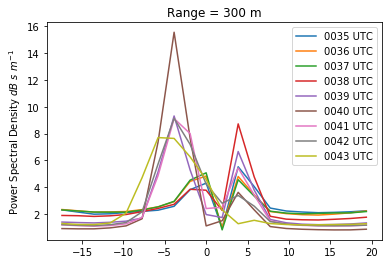

In [135]:
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 35, 00), range=300., method='nearest')*100,
         label='0035 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 36, 00), range=300., method='nearest')*100,
         label='0036 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 37, 00), range=300., method='nearest')*100,
         label='0037 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 38, 00), range=300., method='nearest')*100,
         label='0038 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 39, 00), range=300., method='nearest')*100,
         label='0039 UTC'
         )
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 40, 00), range=300., method='nearest')*100,
         label='0040 UTC'
         )
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 41, 00), range=300., method='nearest')*100,
         label='0041 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 42, 00), range=300., method='nearest')*100,
         label='0042 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 43, 00), range=300., method='nearest')*100,
         label='0043 UTC')
plt.ylabel('Power Spectral Density $dB\ s\ m^{-1}$')
plt.legend()
plt.title('Range = 300 m')

<>:30: DeprecationWarning: invalid escape sequence \ 
<>:30: DeprecationWarning: invalid escape sequence \ 
<>:30: DeprecationWarning: invalid escape sequence \ 
<ipython-input-136-e6744626f073>:30: DeprecationWarning: invalid escape sequence \ 
  plt.ylabel('Power Spectral Density $dB\ s\ m^{-1}$')


Text(0.5, 1.0, 'Range = 2000 m')

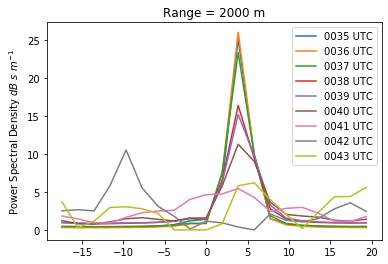

In [136]:
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 35, 00), range=2000., method='nearest')*100,
         label='0035 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 36, 00), range=2000., method='nearest')*100,
         label='0036 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 37, 00), range=2000., method='nearest')*100,
         label='0037 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 38, 00), range=2000., method='nearest')*100,
         label='0038 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 39, 00), range=2000., method='nearest')*100,
         label='0039 UTC'
         )
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 40, 00), range=2000., method='nearest')*100,
         label='0040 UTC'
         )
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 41, 00), range=2000., method='nearest')*100,
         label='0041 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 42, 00), range=2000., method='nearest')*100,
         label='0042 UTC')
plt.plot(my_spectra['vel_bins'], 
         psd.sel(time=datetime.datetime(2017, 8, 4, 0, 43, 00), range=2000., method='nearest')*100,
         label='0043 UTC')
plt.ylabel('Power Spectral Density $dB\ s\ m^{-1}$')
plt.legend()
plt.title('Range = 2000 m')

## Compare against b1 level data

In [45]:
import act
b1_dat_file_path = '/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlfptC1.b1.20170804.000113.cdf'

In [86]:
b1_ds = act.io.armfiles.read_netcdf(b1_dat_file_path)

In [47]:
b1_ds

<xarray.Dataset>
Dimensions:                 (range: 400, time: 2184)
Coordinates:
  * range                   (range) float32 15.0 45.0 75.0 ... 11955.0 11985.0
  * time                    (time) datetime64[ns] 2017-08-04T00:01:13.069990 ... 2017-08-04T00:59:59.899978
Data variables:
    base_time               (time) datetime64[ns] 2017-08-04 ... 2017-08-04
    time_offset             (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    qc_time                 (time) int32 dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth                 (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    elevation               (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    radial_velocity         (time, range) float32 dask.array<chunksize=(2184, 400), meta=np.ndarray>
    qc_radial_velocity      (time, range) int32 dask.array<chunksize=(2184, 400), meta=np.ndarray>
    intensity               (time, range) float32 dask.array<chunksize=(2

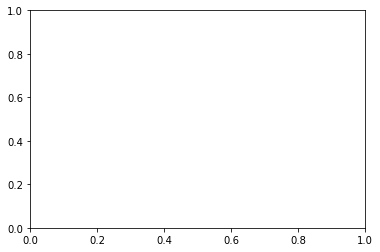

In [48]:
disp = act.plotting.TimeSeriesDisplay(b1_ds)

/home/rjackson/anaconda3/envs/pyart-2019/lib/python3.7/site-packages/act/plotting/plot.py:257: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])


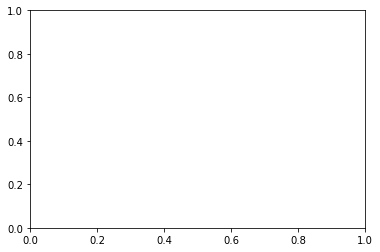

In [51]:
disp.plot('radial_velocity', subplot_index=(0, ))

Text(0.5, 1.0, 'Aug 04 2017, SNR > 0 dB')

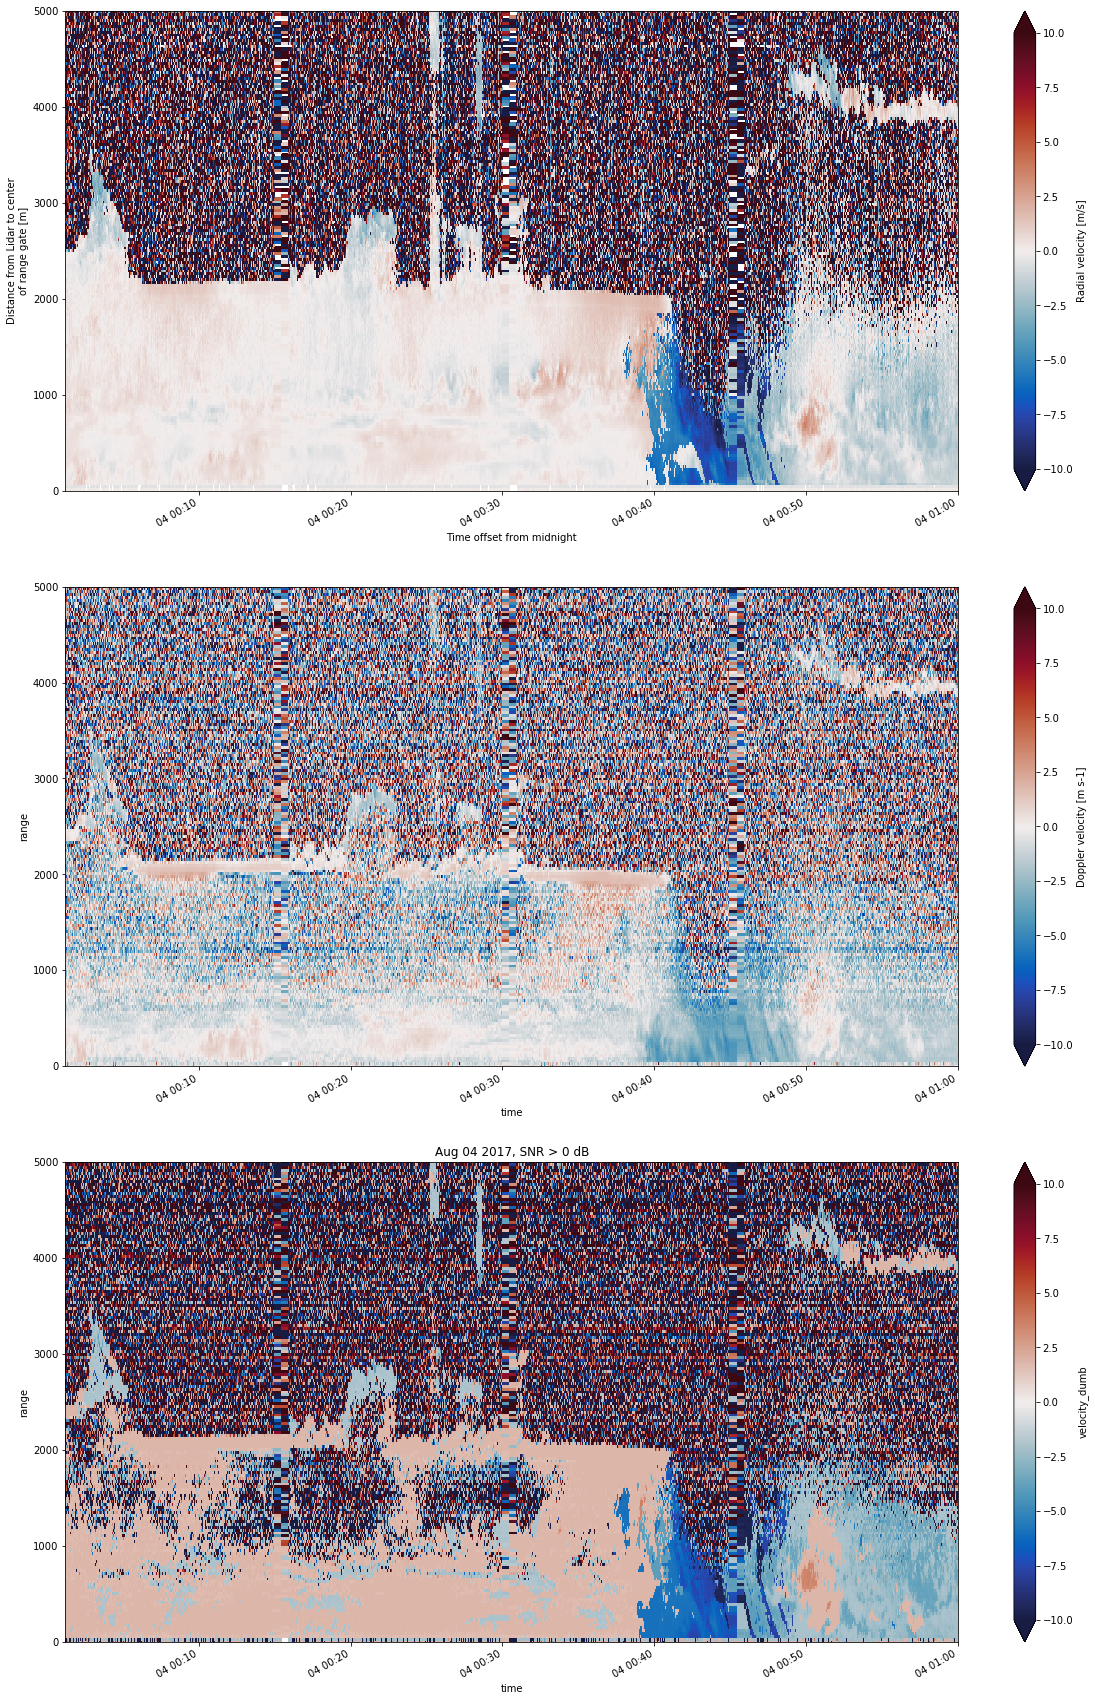

In [474]:
fig, ax = plt.subplots(3, 1, figsize=(20,30))
b1_ds['radial_velocity_masked'] = b1_ds['radial_velocity'].where(b1_ds.intensity > 1)
b1_ds['radial_velocity_masked'].T.plot(cmap='pyart_balance', vmin=-10, vmax=10, ax=ax[0])
ax[0].set_ylim([0, 5000])
my_spectra['mean_velocity'].T.plot(vmin=-10, vmax=10, cmap='pyart_balance', ax=ax[1])
ax[1].set_ylim([0, 5000])
my_spectra['velocity_dumb'].T.plot(vmin=-10, vmax=10, cmap='pyart_balance', ax=ax[2])
ax[2].set_ylim([0, 5000])
plt.title('Aug 04 2017, SNR > 0 dB')

(0, 5000)

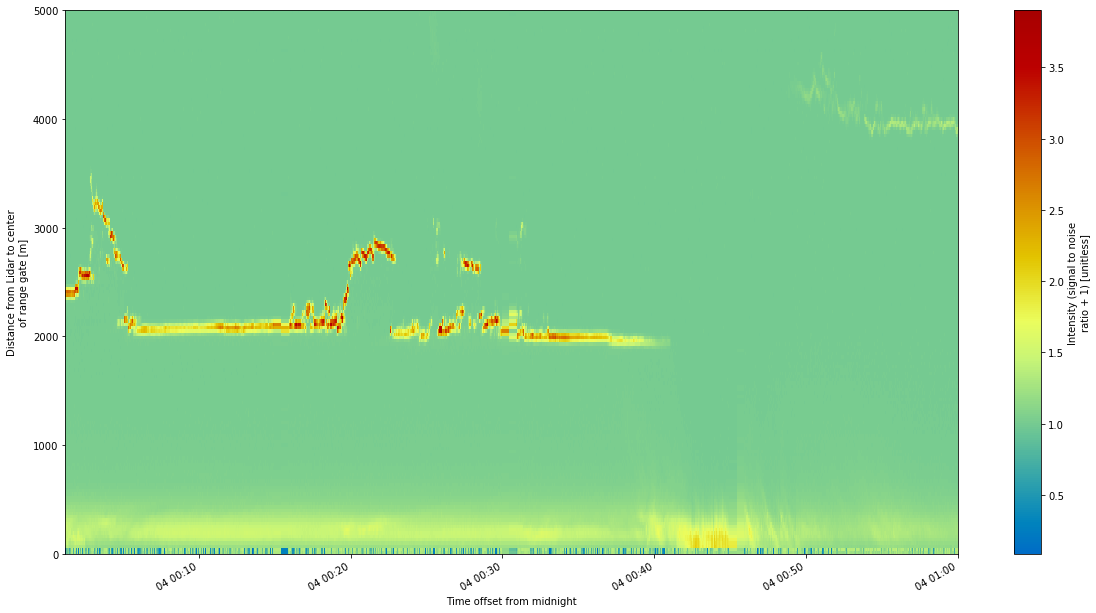

In [444]:
plt.figure(figsize=(20,10))
b1_ds['intensity'].T.plot(cmap='pyart_HomeyerRainbow')
plt.ylim([0, 5000])

In [2]:
from glob import glob
import time
file_list = glob("/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/*.v0")
out_path = '/home/rjackson/lidar_figures'
out_file_path = "/nfs/gce/projects/digr/sgp_gpu_processed_files/"

def make_quicklooks(file_list):
    for file in file_list:
        start_time = time.time()
        print("Processing file %s" % file)
        ds = xr.open_dataset(file)
        my_spectra = get_psd(ds)
        my_spectra = get_power_and_velocity(my_spectra)
        
        fig, ax = plt.subplots(2, 1, figsize=(15, 15))
        my_spectra['intensity'] = my_spectra['snr'] + 1
        my_spectra['intensity'] = my_spectra['intensity'].where(my_spectra['snr'] > 1)
        my_spectra['mean_velocity'] = my_spectra['mean_velocity'].where(my_spectra['snr'] > 1)
        my_spectra['intensity'].T.plot(ax=ax[0], cmap='pyart_HomeyerRainbow', vmin=0, vmax=10)
        ax[0].set_ylim([0, 10000])
        ax[0].set_title(str(my_spectra['time'].values[0]))
        my_spectra['mean_velocity'].T.plot(ax=ax[1], cmap='pyart_balance', vmin=-5, vmax=5)
        ax[1].set_ylim([0, 10000])
        file_name = file.split('/')[-1]
        out_file_name = out_file_path + '/' + file_name[:-6] + '.moments.nc'
        my_spectra = my_spectra.drop('acf')
        my_spectra = my_spectra.drop('acf_bkg')
        my_spectra = my_spectra.drop('nlags')
        my_spectra = my_spectra.drop('complex')
        my_spectra = my_spectra.drop('power_spectral_density')
        my_spectra = my_spectra.drop('power_spectra_normed')
        my_spectra = my_spectra.drop('power_spectral_density_interp')
        my_spectra = my_spectra.drop('power_spectra_normed_interp')
        my_spectra.to_netcdf(out_file_name)
        ds.close()
        my_spectra.close()
        del my_spectra, ds
        
        fig.savefig((out_path + '/' + file_name + ".png"), dpi=300)        
        plt.close(fig)
        print("File processed in %5.2f s" % (time.time() - start_time))

In [13]:
file_list = sorted(file_list)
make_quicklooks(file_list[1313:])

Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.010115.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 168.29 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.020113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 147.68 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.030114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 146.93 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.040114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 149.81 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.050113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.64 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.060113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.02 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.36 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.080114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 118.04 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.090114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.43 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.100114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.00 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.110113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 101.82 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.120114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.92 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.130114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 119.76 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.140114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.54 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.152750.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.28 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.162756.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.70 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.172758.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.74 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.182801.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.35 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.192802.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.90 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.202805.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.90 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.212754.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.06 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.222802.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.24 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170925.230019.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.83 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 102.31 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.010114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 99.13 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.020114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.07 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.030114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 101.75 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.040113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 98.38 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.050113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.75 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.060113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.02 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.09 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.080114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.42 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.090114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 103.24 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.100114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.03 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.110114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 103.14 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.120113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.23 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.130113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.50 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.140114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 102.60 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.150114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 101.80 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.160113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.13 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.170113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 102.52 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.180114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 99.12 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.190113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.33 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.200114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.84 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.210113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.16 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.220114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 99.11 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170926.230113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 102.43 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 103.00 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.010113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.47 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.020114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.20 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.030114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.52 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.040113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.31 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.050112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.75 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.060112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.69 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.71 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.080112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.81 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.090112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.22 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.100112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.45 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.110113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 99.65 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.120113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.50 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.130112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.06 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.140114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 91.25 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.150113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.22 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.160113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 101.90 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.170113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 98.12 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.180112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 93.91 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.190113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 93.78 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.200113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.92 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.210114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.75 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.220113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.01 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170927.230113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.00 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.78 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.010114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.82 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.020113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.98 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.030113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 102.12 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.040113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.36 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.050113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.86 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.060112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.25 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.35 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.080114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.43 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.090113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.05 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.100114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.56 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.110114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.06 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.120113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.69 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.130113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.06 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.140114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.64 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.152817.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  4.80 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.162820.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  4.75 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.172811.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.08 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.182814.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  4.90 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.192810.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.40 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.202802.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.89 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.212755.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.05 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.222758.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.02 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170928.230020.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 114.77 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.57 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.010114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 103.95 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.020114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.20 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.030114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.89 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.040114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 108.08 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.050114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.27 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.060113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.88 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.18 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.080113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 114.95 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.090113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.46 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.100113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.51 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.110112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.74 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.120112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.72 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.130114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.18 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.140112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 114.15 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.152810.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.44 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.162802.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.73 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.172801.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.86 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.182804.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.61 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.192805.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  4.93 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.202805.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.69 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.212800.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.40 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.222807.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  4.58 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170929.230020.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.14 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.88 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.010114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.18 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.020114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.63 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.030114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.81 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.040114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.87 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.050113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 114.42 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.060114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.83 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.93 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.080114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.76 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.090114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.89 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.100113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.98 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.110114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.83 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.120114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.29 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.130113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.83 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.140113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.80 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.152801.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  5.22 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.162752.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.33 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.172747.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  7.24 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.182746.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.43 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.192751.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.27 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.202751.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.93 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.212750.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.77 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.222748.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.86 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170930.230020.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 118.94 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.21 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.010113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.12 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.020114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 102.16 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.030113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.23 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.040114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 99.33 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.050112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.51 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.060114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 98.01 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.070114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.94 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.080113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 100.32 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.090113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 95.60 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.100113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 103.68 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.110113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.27 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.120114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 95.00 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.130113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 99.49 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.140114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.45 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171001.152805.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.73 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.130434.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 94.35 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.140114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.59 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.150113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 106.35 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.160114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 49.12 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.182457.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  1.61 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.211512.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 29.48 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.222748.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.41 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171002.230019.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.33 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.000114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 101.14 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.010113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.02 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.020115.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.99 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.030113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 104.72 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.040114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 115.00 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.050113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 107.49 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.060113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.91 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.070114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.61 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.080114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 116.07 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.090113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.70 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.100114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.39 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.110114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.83 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.120114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.00 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.130114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 66.72 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.145335.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 13.68 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.152758.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.05 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.162751.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.40 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.172747.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.57 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.182750.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.35 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.192750.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.23 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.202747.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.59 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.212748.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  9.40 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.222749.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in  6.72 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171003.230019.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.81 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.000113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.61 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.010113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 112.65 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.020113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 113.16 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.030113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.83 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.040114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.60 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.050113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 109.68 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.060113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.42 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.070113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 110.03 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.080113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 111.58 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.090114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 105.56 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.100114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 115.12 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.110114.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 116.04 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.120112.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 123.31 s
Processing file /run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20171004.130113.nc.v0


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


File processed in 85.49 s


In [42]:
print(file_list[630])

/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/sgpdlacfC1.a1.20170827.060020.nc.v0
